# **Importing Dependencies**

In [1]:
import os
from typing import Any
import nltk
import nltk.internals
import pandas as pd

In [2]:
from pydantic import BaseModel
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

# **Loading the Interviews and Pre-Processing them**


## **Reading interviews from text files**

In [1]:
# interviews =[]
# for i in range(9):
#     with open(f"Deidentified_parents_interview_{i+1}.txt", "r", encoding='utf8') as fp:
#         interview = fp.read()
#         interviews.append(interview)
# interviews

In [4]:
for i in range(9):
    print(len(interviews[i].split()))

11688
12575
11774
11457
11115
10908
8936
12664
7767


## **Splitting text into smaller chunks**

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 8000,
    separators=["\n\n","\n", "Interviewer"],
    length_function=len,
    is_separator_regex=False
)

In [6]:
collection=[]
for interview in interviews:
    doc = text_splitter.create_documents([interview])
    collection.append(doc)

In [7]:
def format_docs(collection):
    texts=[]
    for docs in collection:
        for doc in docs:
            texts.append(doc.page_content)
    return texts

texts = format_docs(collection)

In [2]:
# texts

# **Extracting codes from the interviews**

In [9]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

In [10]:
class Codes(BaseModel):
    Name: str
    Description: str
    Quote: str

parser = JsonOutputParser(pydantic_object=Codes)

In [11]:
open_api_key = ""
os.environ["OPENAI_API_KEY"]=open_api_key
# model_name = "gpt-4o"
model_name = "gpt-4o-mini"
model = ChatOpenAI(model_name = model_name, temperature = 0)

In [12]:
# changed to codes.

prompt_text = """
You are an expert in inductive thematic analysis. You will code the transcript independently, without using a pre-existing codebook. This is the initial coding stage, where insights will be drawn directly from the text. The results from this stage will determine the subsequent theme generation process.

You are provided text from transcripts of interviews with parents of children suffering from Anomalous Aortic Origin of a Coronary Artery (AAOCA). The text is about the desires, wants, and meaningful outcomes of parents related to the experience of living with or caring for children with AAOCA. Some of the children have just undergone open surgery.

In this stage, you will generate codes. Codes are the foundational units of inductive thematic analysis, capturing significant concepts and ideas from the transcripts. Each code includes a concise name, a meaningful description, and representative quotes from the transcripts.

In this task, a 'code' should be related to the desires, needs, and meaningful outcomes for parents of children with AAOCA. Codes pertain to parents. Codes describe the feeling of the parent themselves; how the parent feels towards the child or because of the child.

For example, a code could detail the idea of how a parent fears how the child will reintegrate into social society after surgery, but it could not detail a parent recounting how the child told the parent that the child fears reintegrating into social society.

Your goal is to carefully look through the text and identify all codes discussed by the parents exhaustively. Each code should be very specific and distinct. You will be rewarded $1000 if you can complete this effectively.

Identify all relevant codes in the text, provide a Name for each code in 8 to 15 words in sentence case.

Write with concise, concrete details and avoid clichés, generalizations.

Give a dense Description of the code in 80 words and direct Quotes from the participant for each code in around 120 words. These quotes can consist of multiple excerpts from the text.

Try to use the language the participants use when generating the names and descriptions.

Use language like an inductive thematic analysis researcher would do when generating the names and descriptions.

Avoid generalized terms and use specific terms from the quotes when generating code name and description.

Format the response as a JSON output keeping names, descriptions and quotes together in the JSON, and keep them together in Codes.
The response should start from Codes as a JSON output
text: {text}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

LLMchain = {"text": lambda x:x} | prompt | model | parser

In [13]:
codes = LLMchain.batch(texts, {"max_concurrency": 20})

In [14]:
codes

[{'Codes': [{'Name': "Desire for simplicity in discussing the child's condition",
    'Description': "Parents prefer to simplify the terminology surrounding their child's heart condition, often using acronyms or general terms like 'heart condition' or 'congenital heart defect.' This approach helps them communicate without overwhelming others who may not understand the medical jargon. They aim to protect their child from unnecessary worry and keep discussions straightforward.",
    'Quotes': ["I just say, 'Anomalous right coronary.' That's what I do.",
     "We've kept it simple, anomalous right coronary artery.",
     "Just his heart condition, that's really all we say about it."]},
   {'Name': 'Desire to shield the child from the seriousness of the condition',
    'Description': "Parents express a strong desire to protect their children from the emotional burden of their heart condition. They often choose not to discuss the specifics of the diagnosis in front of their children, aiming

In [15]:
collections = [code['Codes'] for code in codes]
list_of_codes = []
for codes in collections:
    for code in codes:
        list_of_codes.append(code)

In [16]:
df_codes = pd.DataFrame(columns=['Code','Description','Quote'])
for i,code in enumerate(list_of_codes):
        df_codes.loc[i,'Code'] = code['Name']
        df_codes.loc[i,'Description'] = code['Description']
        df_codes.loc[i,'Quote'] = code['Quotes']

df_codes

,Code,Description,Quote
0,Desire for simplicity in discussing the child'...,Parents prefer to simplify the terminology sur...,"[I just say, 'Anomalous right coronary.' That'..."
1,Desire to shield the child from the seriousnes...,Parents express a strong desire to protect the...,[I wouldn't even let my son know about it. I d...
2,Relief after surgery but facing ongoing uncert...,Parents report feeling a sense of relief after...,"[At this point, we're in the relief stage, but..."
3,Emotional impact of navigating medical care,Parents describe the emotional challenges they...,[The negative effects were emotional and that ...
4,Desire for clarity about the child's future he...,Parents express a strong desire for clarity re...,"[We still have a little bit of doubt there, bu..."
...,...,...,...
397,The need for advocacy and informed decision-ma...,Parents express the importance of being proact...,[I think it would just be to advocate for your...
398,Desire for supportive and communicative health...,Parents express a strong desire for healthcare...,[Our doctor encouraged us to get a second opin...
399,Need for clear and comprehensive information a...,Parents wish they had received clearer informa...,[I wish I would've known that the official dia...
400,Concern about follow-up care and specialist ac...,Parents express concern about the follow-up ca...,[I wish that they would've demanded that we ha...


In [17]:
# get a time stamp for the file name
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
df_codes.to_csv(f"df_codes_parents{now}_{model_name}.csv", index=False)

## **Finding major themes from the unique codes**

In [18]:
class Themes(BaseModel):
    Name: str
    Description: str
    Original_Codes: list[str]
    
parser = JsonOutputParser(pydantic_object=list[Themes])

In [19]:
# Prompt for generating initial themes from each chunk
chunk_prompt_template = """
You are working on Inductive Thematic Analysis. This is the theme identification stage. You are provided results from the initial code stage: text that has initial codes with their descriptions and relevant Quotes.

These initial codes are generated from interview transcripts of parents of children suffering from Anomalous Aortic Origin of a Coronary Artery (AAOCA). It is about the desires, wants and outcomes of parents related to the experience of living with or caring for children with AAOCA. Some of the children have just undergone open surgery.

Your task at this stage is to group the initial codes into distinct themes based on the initial codes, descriptions, and quotes.

A 'theme' is the wants, needs, meaningful outcomes, and lived experiences of parents of individuals diagnosed with AAOCA. Achieving these would be successful in caring for the condition from the parents perspective.

Themes pertain to parents. Themes describe the feeling of the parent themselves; how the parent feels towards the child or because of the child.

For example, a theme could detail the idea of how a parent fears how the child will reintegrate into social society after surgery, but it could not detail a parent recounting how the child told the parent that the child fears reintegrating into social society.

Each theme should be specific and distinct.

Codes can be in more than one theme. Each theme should be distinct and cover a set of codes that are related to each other. List all the relevant codes under each major theme.

Provide a descriptive and specific name of 8 to 15 words for each theme based on the code's names, quotes and descriptions.

The name of the themes are the desires, needs, and most meaningful outcomes for parents of children with AAOCA.

Write with concise, concrete details and avoid clichés, generalizations. Avoid the word 'Navigating' in the names.

Try to use the language the participants use when generating the theme names and descriptions.

The theme name should be an action with the subject being parents. Omit the default subject (parents) and the disease from the name.

Write the theme name in sentence case.

Provide a detailed description of 60 to 80 words for each theme.

Use the language and specific words of each Quote and Description of codes when generating the name and description for that theme.

Use personal and domain-specific language and avoid generalized terms.

Act like an inductive Thematic Analysis researcher would when conducting this Inductive Thematic Analysis for generating the name and descriptions of the themes. You will be rewarded $1000 if you can complete this effectively. 

Also provide all the initial codes that fall under that theme.

Format the response as a JSON output, keeping Name, Description, and all Codes under 'Themes' together in the JSON.

text = {text}
"""
chunk_prompt = ChatPromptTemplate.from_template(chunk_prompt_template)

In [21]:
# Function to format data for the prompt
def format_dataframe(df):
    text = ""
    for _, row in df.iterrows():
        text += f"Initial Codes: {row['Code']}, Description: {row['Description']}, Quotes: {row['Quote']}\n"
    return text

# Step 1: Split data into chunks
chunk_size = 67  # Adjust based on input length limits and complexity
chunks = [df_codes[i:i + chunk_size] for i in range(0, len(df_codes), chunk_size)]

In [22]:
# Step 2: Process each chunk independently to gather preliminary themes
all_initial_themes = []
for chunk in chunks:
    text = format_dataframe(chunk)
    # Process each chunk to generate preliminary themes
    response = chunk_prompt | model | parser
    chunk_themes = response.invoke({"text": text}, max_concurrency=20)
    print(chunk_themes)

    if isinstance(chunk_themes, dict) and "Themes" in chunk_themes:
        chunk_themes = chunk_themes["Themes"]
        all_initial_themes.append(chunk_themes)
    elif isinstance(chunk_themes, dict) and "themes" in chunk_themes:
        chunk_themes = chunk_themes["themes"]
        all_initial_themes.append(chunk_themes)
    else:
        print("Unexpected response format:", chunk_themes)
        all_initial_themes.append(chunk_themes)

{'Themes': [{'Name': "Seeking clarity and reassurance about the child's health journey", 'Description': "Parents express a strong desire for clarity and reassurance regarding their child's health and future. They often feel overwhelmed by uncertainties and seek comprehensive information from medical professionals about long-term outcomes, treatment options, and follow-up care. This need for clarity is coupled with anxiety about potential complications and the emotional toll of navigating a complex medical landscape, reflecting their quest for understanding amidst the unknown.", 'Codes': ["Desire for clarity about the child's future health", 'Fear of long-term outcomes after surgery', 'Concerns about follow-up care and future health', 'Desire for statistical data on condition outcomes', 'Desire for comprehensive data on surgery outcomes for reassurance', 'Desire for clear communication and information from healthcare providers']}, {'Name': "Balancing normalcy and protection in the child

In [23]:
# groups = [group for sublist in all_initial_themes for group in parser.invoke(sublist)['Groups']]
groups = [group for sublist in all_initial_themes for group in sublist]

for group in groups:
    print(group)

{'Name': "Seeking clarity and reassurance about the child's health journey", 'Description': "Parents express a strong desire for clarity and reassurance regarding their child's health and future. They often feel overwhelmed by uncertainties and seek comprehensive information from medical professionals about long-term outcomes, treatment options, and follow-up care. This need for clarity is coupled with anxiety about potential complications and the emotional toll of navigating a complex medical landscape, reflecting their quest for understanding amidst the unknown.", 'Codes': ["Desire for clarity about the child's future health", 'Fear of long-term outcomes after surgery', 'Concerns about follow-up care and future health', 'Desire for statistical data on condition outcomes', 'Desire for comprehensive data on surgery outcomes for reassurance', 'Desire for clear communication and information from healthcare providers']}
{'Name': "Balancing normalcy and protection in the child's life", 'De

In [41]:
# Step 3: Consolidate all initial themes
consolidation_prompt_template = """
You are conducting Inductive Thematic Analysis. You are at the final theme generation stage. You are provided preliminary themes, with their descriptions and relevant codes under them.

These preliminary themes and codes are generated from interview transcripts of parents of children suffering from Anomalous Aortic Origin of a Coronary Artery (AAOCA). It is about the desires and wants of parents related to the experience of living with or caring for children with AAOCA. Some of the children have just undergone open surgery.

A 'theme' is the wants, needs, meaningful outcomes, and lived experiences of parents of individuals diagnosed with AAOCA.

Themes pertain to parents. Themes describe the feeling of the parent themselves; how the parent feels towards the child or because of the child.

For example, a theme could detail the idea of how a parent fears how the child will reintegrate into social society after surgery, but it could not detail a parent recounting how the child told the parent that the child fears reintegrating into social society.

Review and consolidate the following preliminary themes into 12 overarching major themes.

Each major theme should be distinct from the others.

The major themes will be used to write the final report.

A code can appear in multiple major themes if relevant.
List all the relevant codes under each major theme.

Use personal and domain-specific language and avoid generalized terms to generate names and descriptions of the final themes.

Write with concise, concrete details and avoid clichés and generalizations. Avoid the word 'Navigating' in the names.

Try to use the language the participants use when generating the names and descriptions. Directly use the language from the quotes and descriptions.

The final theme name should be an action with the subject being parents. Although omit the default subject (parents) and the disease from the name.

Write the final theme name in sentence case.

The name of the theme should consist of 8 to 15 words.

Each final theme should have a description of 60 to 80 words and list all relevant codes.

Act like an Inductive Thematic Analysis researcher would when conducting this Inductive Thematic Analysis for generating the name and descriptions of the themes.

The name of the themes are the desires, needs, and most meaningful outcomes for parents of children with AAOCA. Achieving these would be successful in caring for the condition from the parents perspective. You will be rewarded $1000 if you can complete this effectively.

Review and consolidate the following preliminary themes into 12 overarching major themes.

Preliminary themes:
{themes}

Format the response as a JSON output with major themes, each containing the name, Description, and relevant Codes.

"""
consolidation_prompt = ChatPromptTemplate.from_template(consolidation_prompt_template)

In [42]:
# Prepare input for the consolidation step
consolidation_text = "\n".join([f"Theme: {theme['Name']}, Description: {theme['Description']}, Codes: {', '.join(theme['Codes'])}" for 
                                sublist in all_initial_themes for theme in sublist])

In [43]:
consolidation_text

"Theme: Seeking clarity and reassurance about the child's health journey, Description: Parents express a strong desire for clarity and reassurance regarding their child's health and future. They often feel overwhelmed by uncertainties and seek comprehensive information from medical professionals about long-term outcomes, treatment options, and follow-up care. This need for clarity is coupled with anxiety about potential complications and the emotional toll of navigating a complex medical landscape, reflecting their quest for understanding amidst the unknown., Codes: Desire for clarity about the child's future health, Fear of long-term outcomes after surgery, Concerns about follow-up care and future health, Desire for statistical data on condition outcomes, Desire for comprehensive data on surgery outcomes for reassurance, Desire for clear communication and information from healthcare providers\nTheme: Balancing normalcy and protection in the child's life, Description: Parents grapple w

In [44]:
# Create final prompt for consolidation
final_response = consolidation_prompt | model | parser
final_themes = final_response.invoke({"themes": consolidation_text}, max_concurrency=20)

In [45]:
final_themes

{'major_themes': [{'name': "Seeking clarity and reassurance about my child's health journey",
   'description': "Parents express a strong desire for clarity and reassurance regarding their child's health and future. They often feel overwhelmed by uncertainties and seek comprehensive information from medical professionals about long-term outcomes, treatment options, and follow-up care. This need for clarity is coupled with anxiety about potential complications and the emotional toll of navigating a complex medical landscape.",
   'codes': ["Desire for clarity about the child's future health",
    'Fear of long-term outcomes after surgery',
    'Concerns about follow-up care and future health',
    'Desire for statistical data on condition outcomes',
    'Desire for comprehensive data on surgery outcomes for reassurance',
    'Desire for clear communication and information from healthcare providers']},
  {'name': "Balancing normalcy and protection in my child's life",
   'description': '

In [46]:
collections = final_themes['major_themes']
# collections = final_themes
df_themes = pd.DataFrame(columns=['Theme','Description','Original_Codes'])
for i,theme in enumerate(collections):
    df_themes.loc[i,'Theme'] = theme['name']
    df_themes.loc[i,'Description'] = theme['description']
    df_themes.loc[i,'Original_Codes'] = theme['codes']

df_themes

,Theme,Description,Original_Codes
0,Seeking clarity and reassurance about my child...,Parents express a strong desire for clarity an...,[Desire for clarity about the child's future h...
1,Balancing normalcy and protection in my child'...,Parents grapple with the desire for their chil...,[Desire for normalcy in the child's life despi...
2,Coping with emotional turmoil and uncertainty ...,Parents articulate the emotional burden and tu...,"[Emotional turmoil over surgical decisions, Em..."
3,Desiring emotional support and understanding f...,Parents emphasize the importance of receiving ...,[Emotional support from medical professionals ...
4,Experiencing relief and gratitude for successf...,Parents convey profound relief and gratitude w...,[Relief and gratitude for successful medical i...
5,Living with constant vigilance and fear of hea...,Parents live in a state of heightened alertnes...,[Constant vigilance and fear of sudden health ...
6,Struggling with guilt and self-blame regarding...,Parents often grapple with feelings of guilt a...,"[Guilt over potential inaction and regret, Gui..."
7,Desiring positive messaging about health outcomes,"Parents express a strong desire for clear, pos...",[Desire for positive messaging about AAOCA out...
8,Feeling overwhelmed by the demands of caregiving,Parents express feelings of being overwhelmed ...,[Feeling overwhelmed by the demands of caring ...
9,Building a supportive community with other par...,Parents actively seek support and community fr...,[Seeking support and community from other pare...


In [47]:
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
df_themes.to_csv(f"df_themes_parents{now}_{model_name}_long.csv", index=False)

In [48]:
length = 0
for codes in df_themes['Original_Codes']:
    length += len(codes)

length

42

## **Comparison with annotated themes developed by humans**

In [49]:
import pandas as pd
df_themes = pd.read_csv("zero_shot.csv")

In [50]:
with open("AAOCA_Parents_outcomes_themes.txt",
          encoding='utf8') as fp:
    human_themes = fp.read()

In [51]:
with open("AAOCA_Parents_outcomes.txt",
          encoding='utf8') as fp:
    human_themes_description = fp.read()

In [52]:
human_themes_split = human_themes.split('\n\n')
descriptions_split = human_themes_description.split("\n\n")

In [53]:
df_human_themes = pd.DataFrame(columns=['Theme','Description', 'Codes'])
for i,theme in enumerate(human_themes_split):
    theme_split = theme.split(':')
    df_human_themes.loc[i,'Codes'] = theme_split[1].split('\n')[1:]

In [54]:
indexes = [11,6,10,1,4,5,8,2,7,0,9,3]

In [55]:
for i,(ind,description) in enumerate(zip(indexes,descriptions_split)):
    description_split = description.split(":\n")
    # print(description_split)
    df_human_themes.loc[ind, 'Theme']=description_split[0]
    df_human_themes.loc[ind, 'Description']=description_split[1]

In [56]:
for i in df_human_themes['Theme']:
    print(i)

Clarity of potential risks and outcomes
Freedom from hypervigilance related to the condition
The diagnosis given in a compassionate and empathic way
A sense of control over the future
Being heard and taken seriously by clinicians
Individualized support for management decision-making
Receiving support from others
Being appropriately informed
Partnership with the care team
Feeling that my child is safe
Not feeling responsible for the diagnosis and its timing
Appropriately coping with stress, anxiety and depression


In [57]:
# df_human_themes.to_csv("df_human_themes_parents.csv", index=False)

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util

d:\software-acsii\mini\envs\daily\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluation

# all-mpnet-base-v2

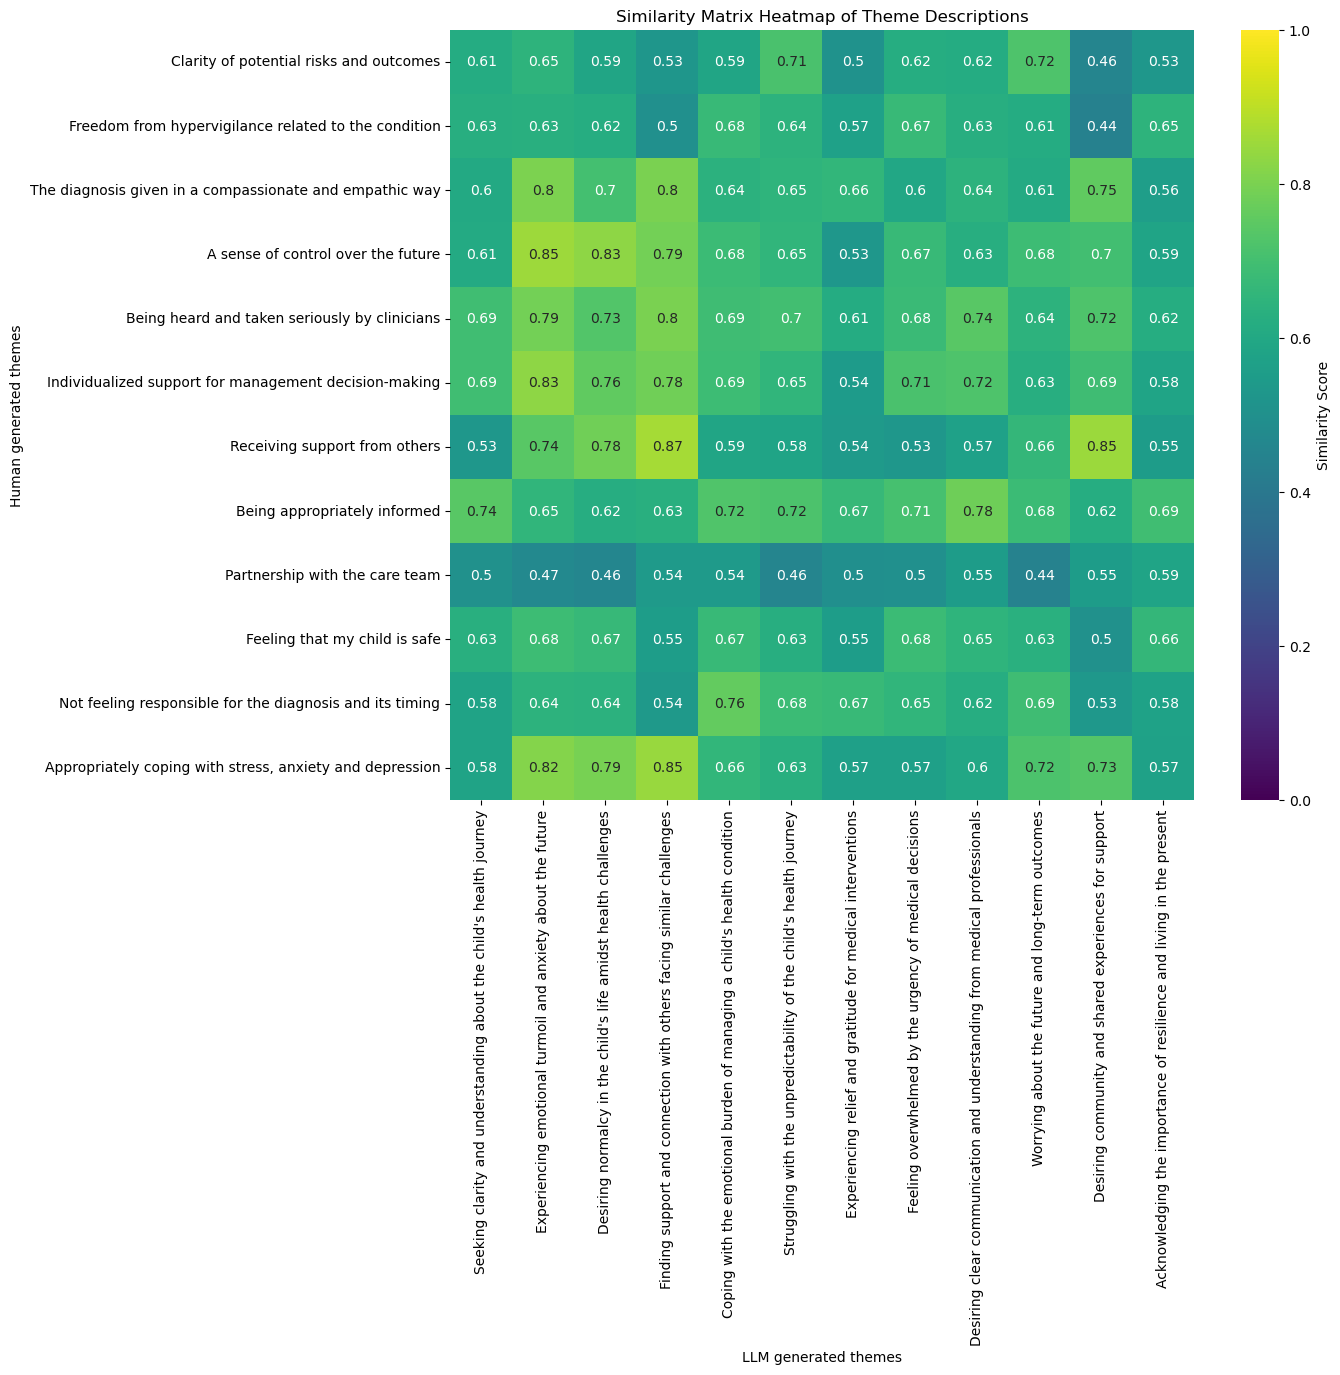

In [59]:
model_name_eval = "all-mpnet-base-v2"

import matplotlib.pyplot as plt
import seaborn as sns

model = SentenceTransformer(model_name_eval)

human_desc_embeddings = model.encode(df_human_themes['Description'].tolist(), convert_to_tensor=True)
llm_desc_embeddings = model.encode(df_themes['Description'], convert_to_tensor=True)

cosine_sim_matrix = util.pytorch_cos_sim(human_desc_embeddings,llm_desc_embeddings).numpy()

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

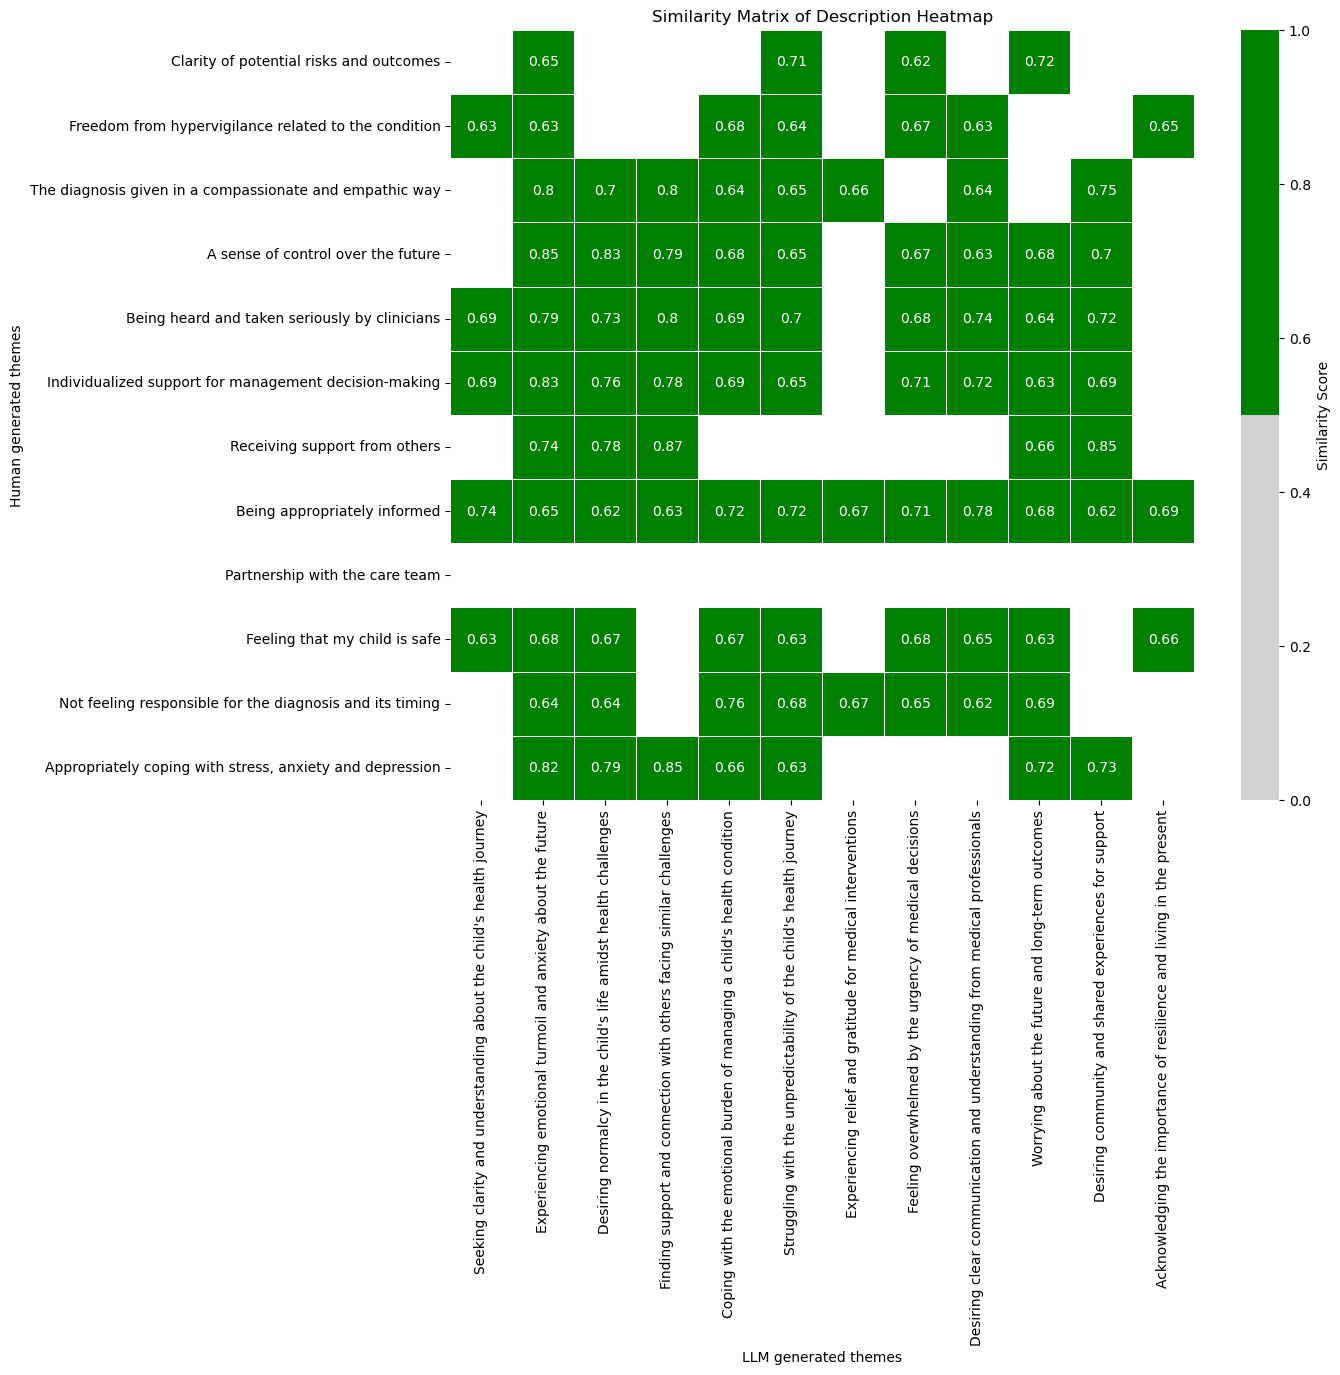

In [61]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= .62),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [ ]:
print(f'{model_name_eval} Threshold: .62')
print('Human vs LLM')
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array > .62)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_desc_df.to_numpy()
total_hit = np.sum(np.any(similarity_array > .62, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

all-mpnet-base-v2 Threshold: .62
Human vs LLM
Jarcard. 0.618
Hit Rate. 0.917


# all-MiniLM-L6-v2

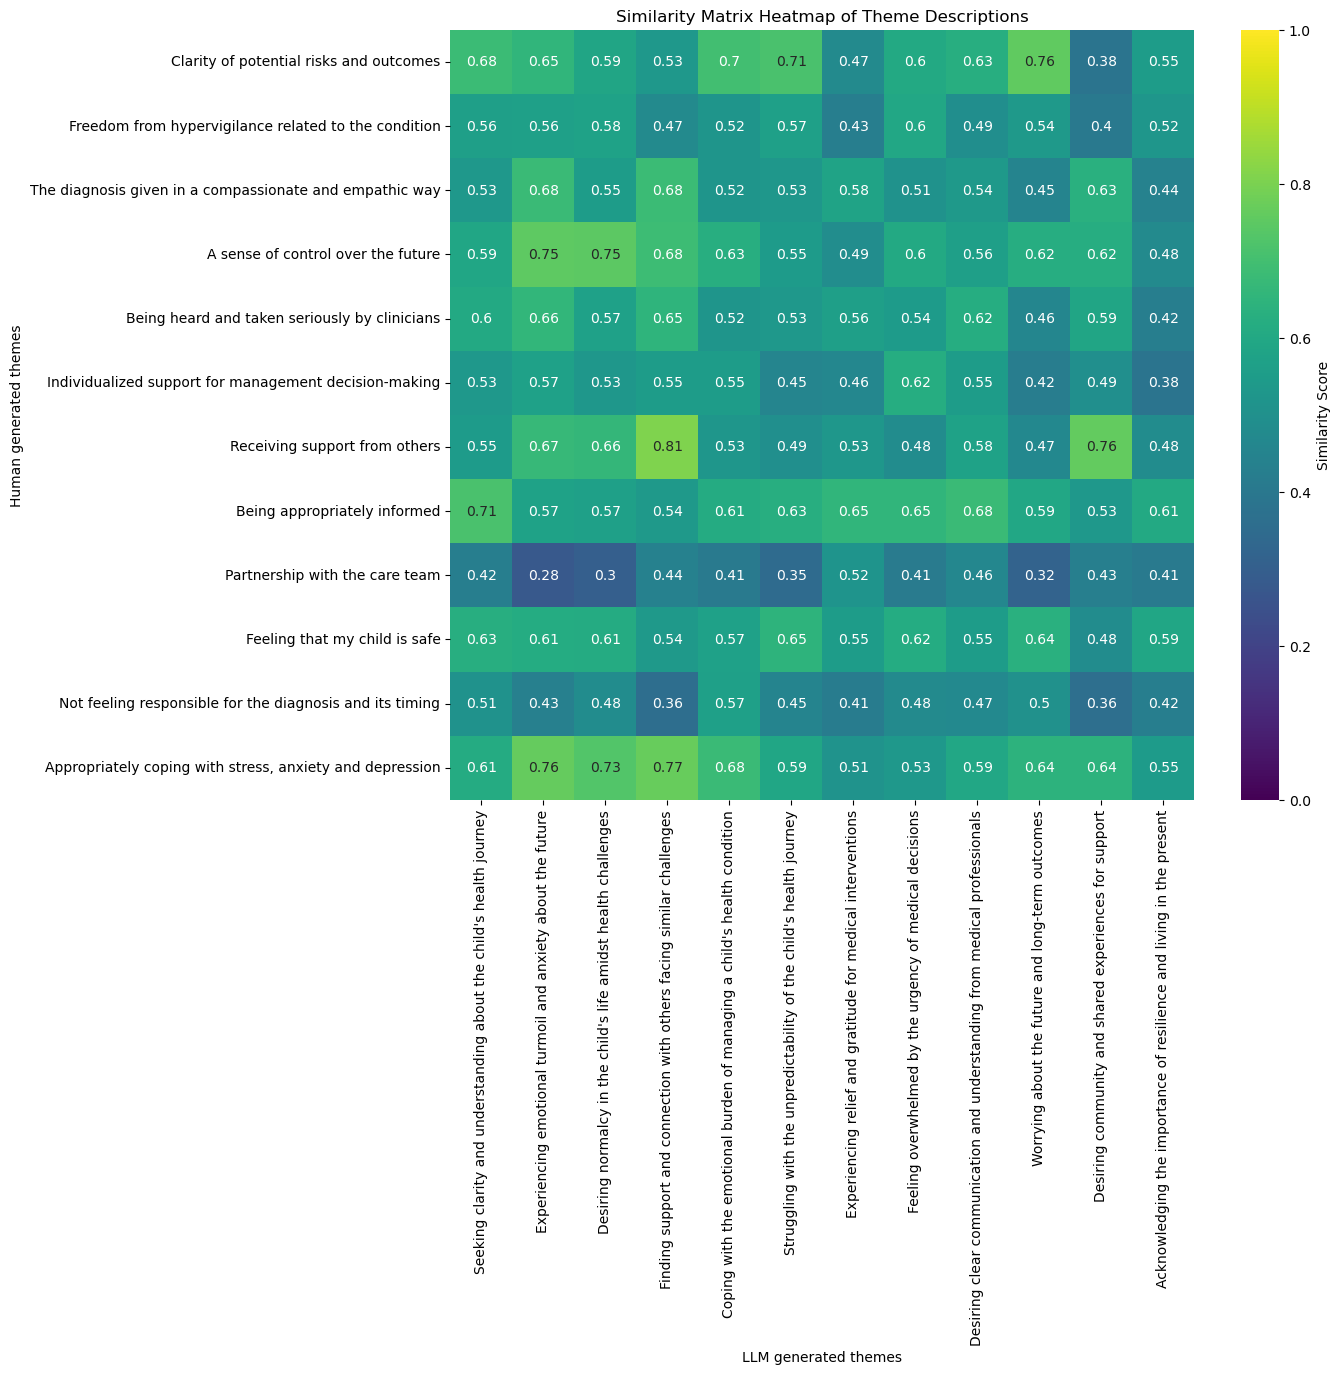

In [ ]:
model_name_eval = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name_eval)

human_desc_embeddings = model.encode(df_human_themes['Description'].tolist(), convert_to_tensor=True)
llm_desc_embeddings = model.encode(df_themes['Description'].tolist(), convert_to_tensor=True)

cosine_sim_matrix = util.pytorch_cos_sim(human_desc_embeddings,llm_desc_embeddings).numpy()

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

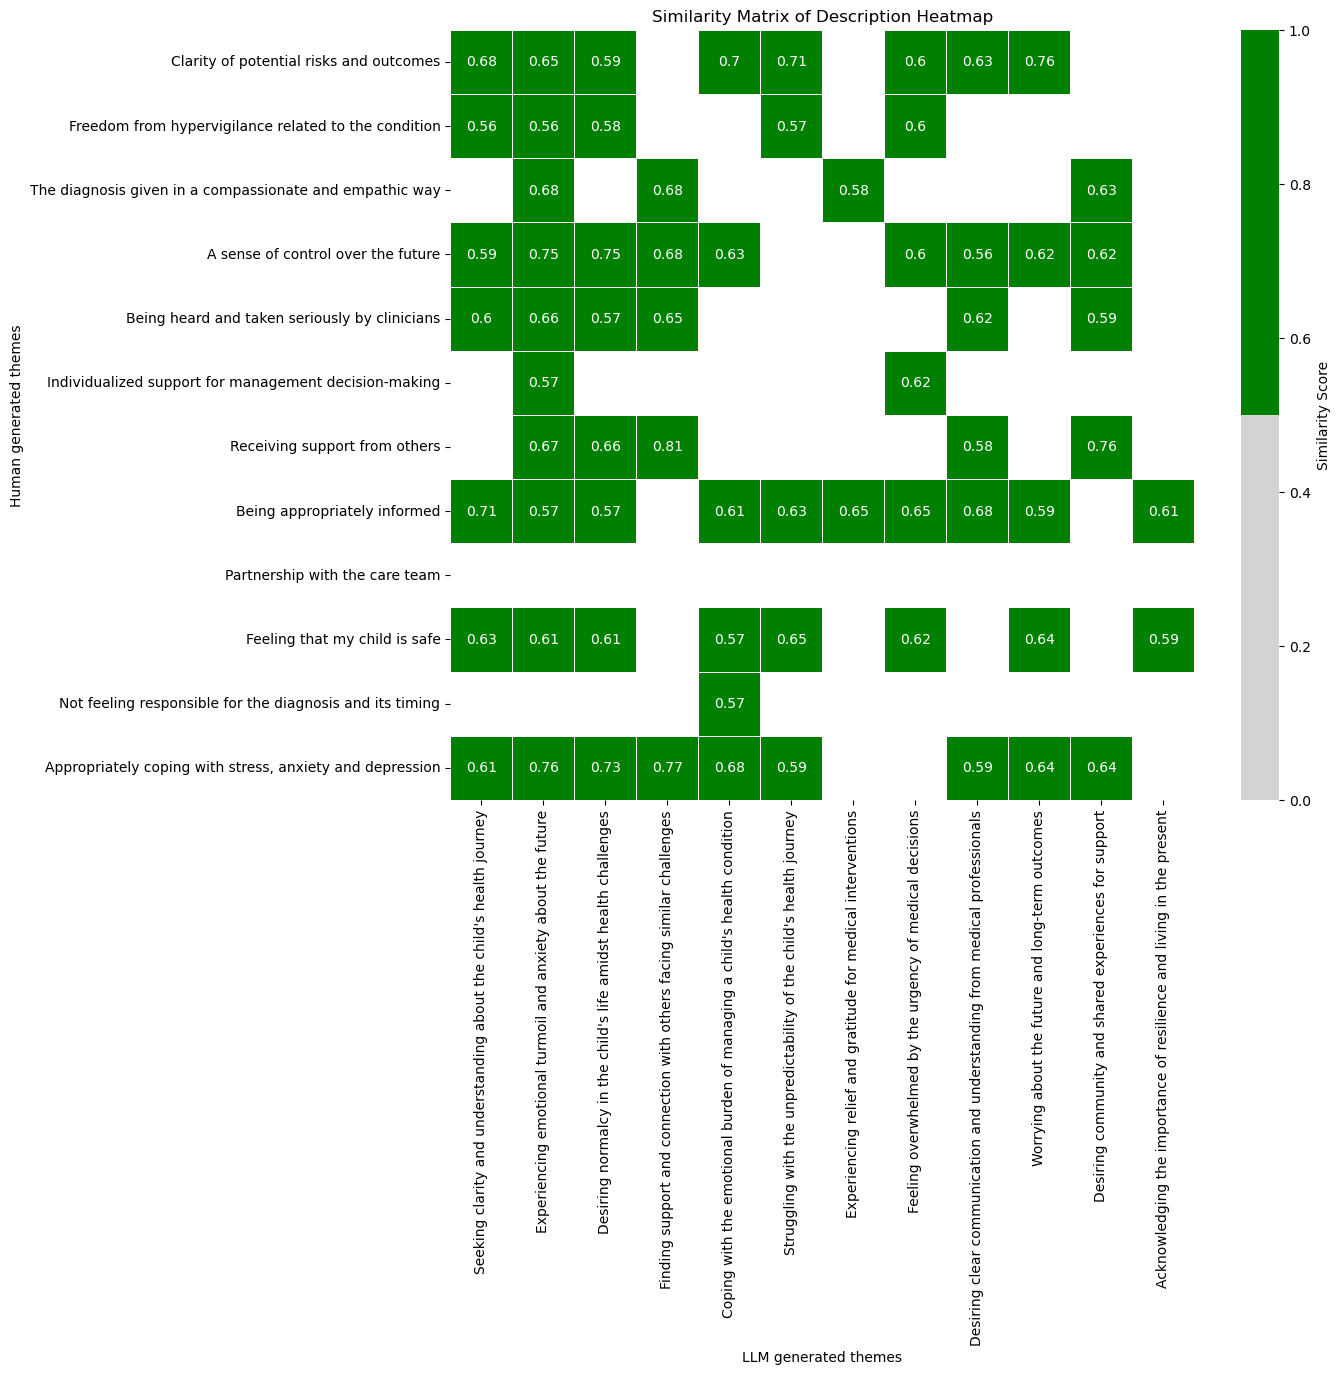

In [ ]:
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= .56),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [ ]:
print(f'{model_name_eval} Threshold: {round(threshold,5)}')
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array > .56)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_desc_df.to_numpy()
total_hit = np.sum(np.any(similarity_array > .56, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

all-MiniLM-L6-v2 Threshold: 0.4
Jarcard. 0.465
Hit Rate. 0.917


## **LLM Based Evaluation**

In [ ]:
def format_rows(llm_row, human_row):
    text = ""
    text += f"Theme 1 Name: {llm_row['Theme']}, Theme 1 Description: {llm_row['Description']}, Theme 2 Name: {human_row['Theme']},  Theme 2 Description: {human_row['Description']} "
    return text

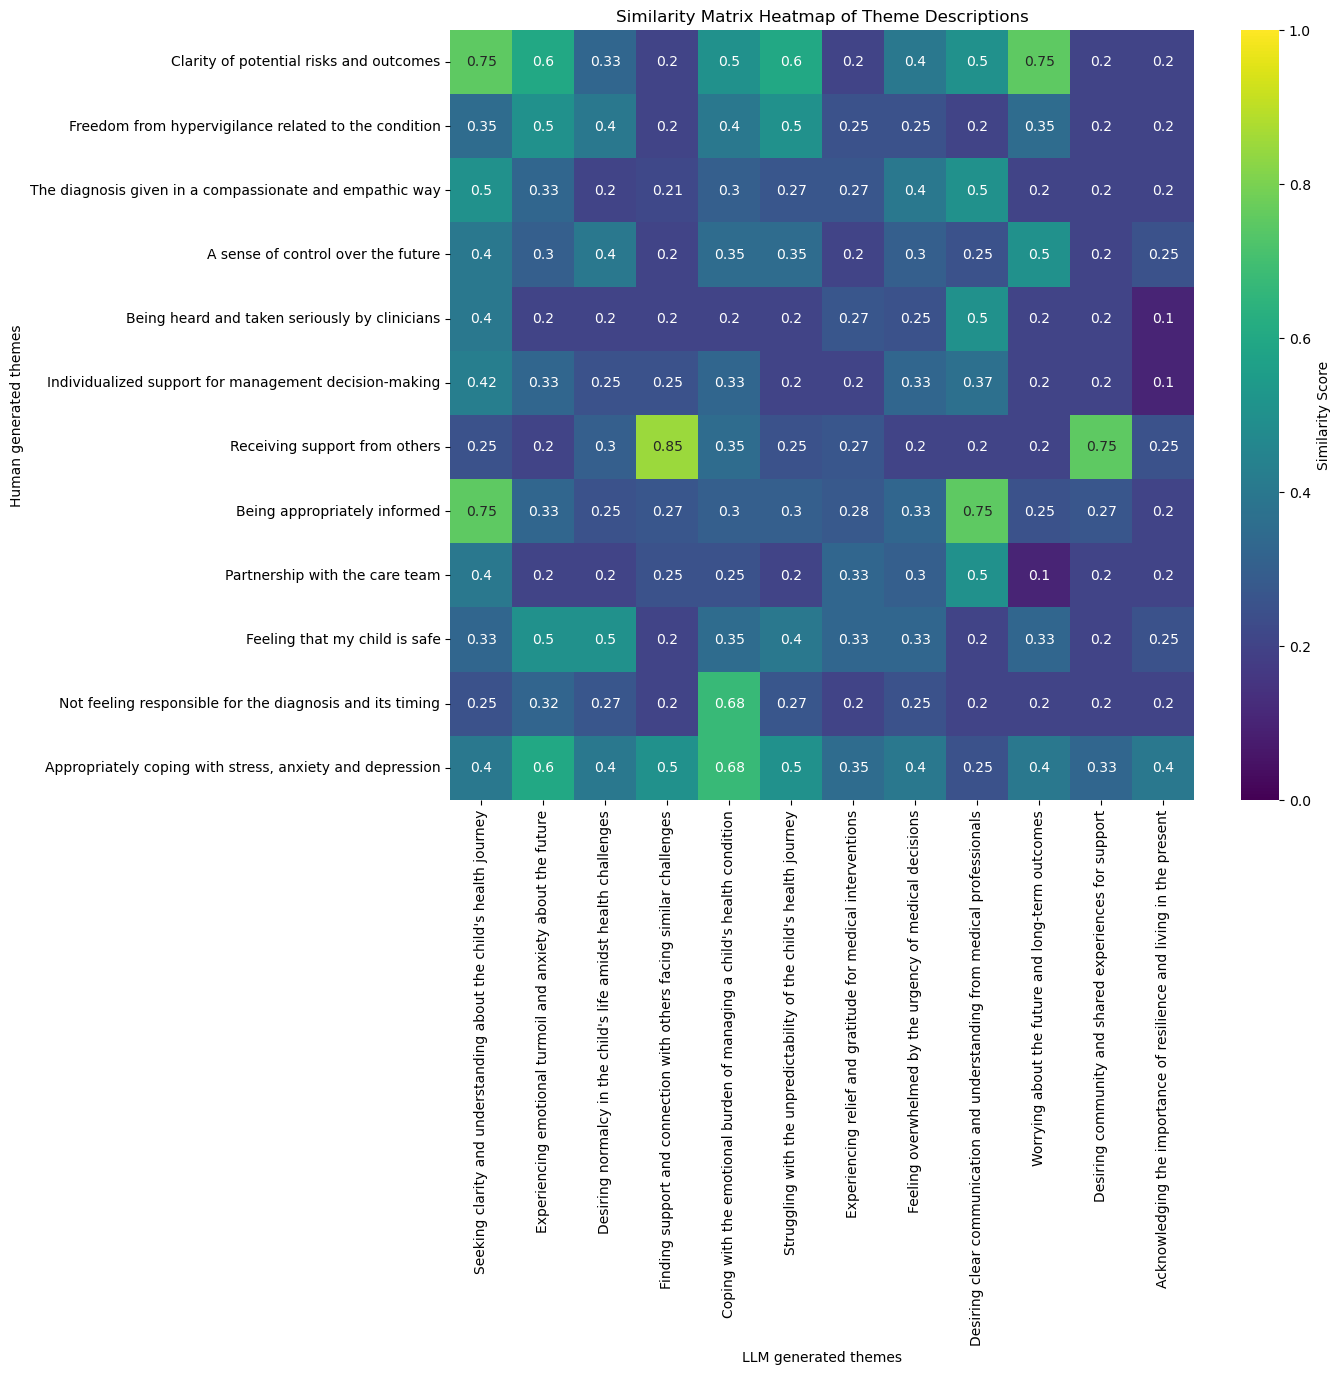

In [ ]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

model_name_eval = "GPT-4o-mini"

open_api_key = ""
import os
os.environ["OPENAI_API_KEY"]=open_api_key
model_name = "gpt-4o-mini"

model = ChatOpenAI(model_name = "gpt-4o-mini", temperature = 0)
parser = StrOutputParser()
prompt_template = """
You are a qualitative research expert conducting inductive thematic analysis.  
Your task is to assess the similarity between two themes based on their names and descriptions.  

The similarity measures how much the two themes convey the same meaning, considering both overlapping ideas, concepts and the specificity of their names and descriptions.
If one of the themes are more general than the other significantly, the similarity score should be lower.
Rate the similarity on a scale from 0 to 1:  
- 1 indicates the themes are identical.  
- 0 indicates they are entirely different.

Provide the similarity score as a single number rounded to three decimal places. Output **only the number**.  
Text: {text}  

Similarity Score:
"""
prompt = ChatPromptTemplate.from_template(prompt_template)
LLMchain = prompt | model | parser
similarity_matrix_llm = pd.DataFrame(index=df_human_themes['Theme'], columns=df_themes['Theme'])
for i, llm_row in df_themes.iterrows():
    for j, human_row in df_human_themes.iterrows():
        text = format_rows(llm_row, human_row)
        response = LLMchain.invoke({"text": text})
        similarity_score = float(response)
        similarity_matrix_llm.at[human_row['Theme'], llm_row['Theme']] = similarity_score
similarity_llm_df=similarity_matrix_llm.iloc[:,:].astype(float)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_llm_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

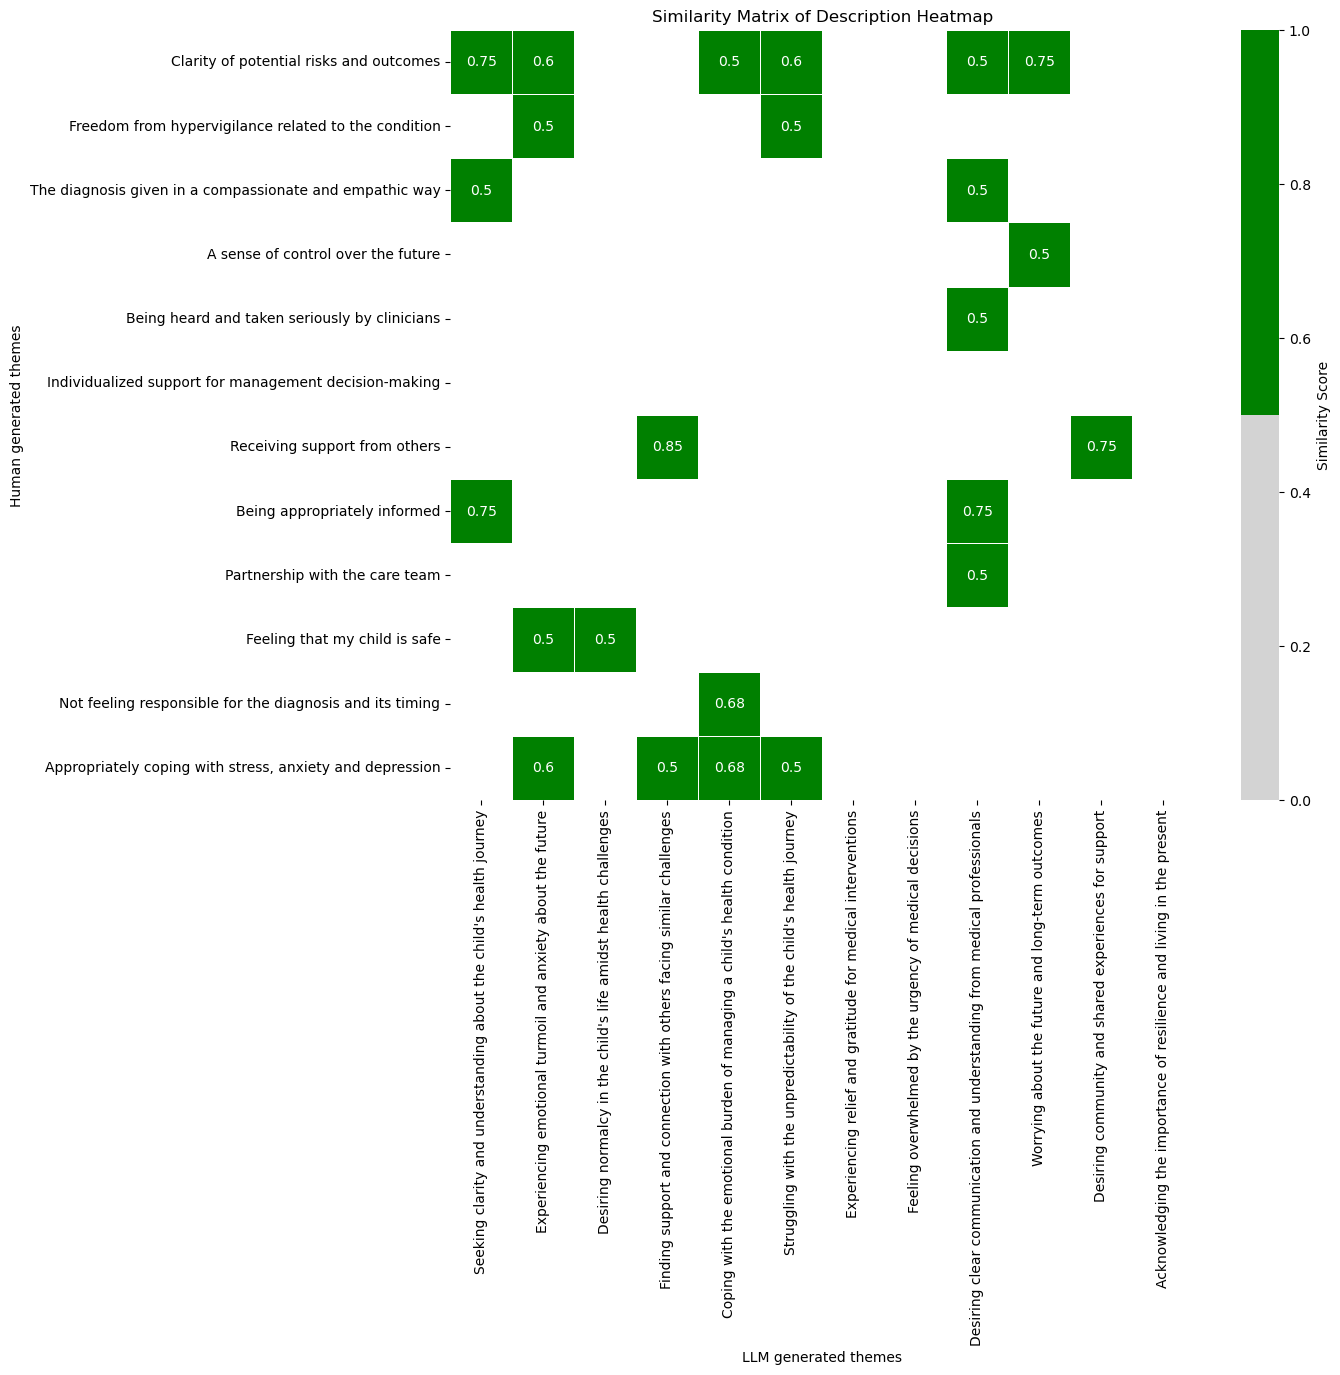

In [ ]:
from matplotlib.colors import ListedColormap
threshold = np.quantile(similarity_llm_df, 0.80)
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_llm_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_llm_df < .5),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [ ]:
print(f'{model_name_eval} Threshold: {round(threshold,2)}')
similarity_array = similarity_llm_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array > .5)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_llm_df.to_numpy()
total_hit = np.sum(np.any(similarity_array > .5, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

GPT-4o-mini Threshold: 0.4
Jarcard. 0.167
Hit Rate. 0.917
